## High-Dimensional sample-efficient Bayesian Optimization with SAASBO

This tutorial shows how to use the Sparse Axis-Aligned Subspace Bayesian Optimization (SAASBO) 
method for high-dimensional Bayesian optimization [1]. SAASBO places strong priors on the 
inverse lengthscales to avoid overfitting in high-dimensional spaces. Specifically, SAASBO 
uses a hierarchical sparsity prior consisting of a global shrinkage parameter 
$\tau \sim \mathcal{HC}(\beta)$ and inverse lengthscales $\rho_d \sim \mathcal{HC}(\tau)$ 
for $d=1, \ldots, D$, where $\mathcal{HC}$ is the half-Cauchy distribution. 
While half-Cauchy priors favor values near zero they also have heavy tails, which allows the 
inverse lengthscales of the most important parameters to escape zero. To perform inference in the 
SAAS model we use Hamiltonian Monte Carlo (HMC) as we found that to outperform MAP inference.

We find that SAASBO performs well on problems with hundreds of dimensions. As we rely on HMC 
and in particular the No-U-Turn-Sampler (NUTS) for inference, the overhead of SAASBO scales 
cubically with the number of datapoints. Depending on the problem, using more than a few hundred
evaluations may not be feasible as SAASBO is designed for problems with a limited evaluation budget.

[1]: [D. Eriksson, M. Jankowiak. High-Dimensional Bayesian Optimization with Sparse Axis-Aligned Subspaces. Proceedings of the Thirty-Seventh Conference on Uncertainty in Artificial Intelligence, 2021.](https://proceedings.mlr.press/v161/eriksson21a.html)

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from botorch import fit_fully_bayesian_model_nuts
from botorch.acquisition import qExpectedImprovement
from botorch.models.fully_bayesian import SaasFullyBayesianSingleTaskGP
from botorch.models.transforms import Standardize
from botorch.optim import optimize_acqf
from botorch.test_functions import Branin
from torch.quasirandom import SobolEngine


%matplotlib inline
SMOKE_TEST = os.environ.get("SMOKE_TEST")

In [2]:
tkwargs = {"device": torch.device("cuda" if torch.cuda.is_available() else "cpu"), "dtype": torch.double}

## Simple model fitting
We generate a simple function that only depends on the first parameter and show that the SAAS
model sets all other lengthscale to large values.

In [3]:
train_X = torch.rand(10, 4, **tkwargs)
test_X = torch.rand(5, 4, **tkwargs)
train_Y = torch.sin(train_X[:, :1])
test_Y = torch.sin(test_X[:, :1])

In [4]:
saas_gp = SaasFullyBayesianSingleTaskGP(train_X=train_X, train_Y=train_Y)
fit_fully_bayesian_model_nuts(saas_gp)
with torch.no_grad():
    posterior = saas_gp.posterior(test_X, marginalize_over_mcmc_samples=True)

Sample: 100%|██████████| 768/768 [00:31, 24.32it/s, step size=4.51e-01, acc. prob=0.907]


Test predictions are very close to the ground-truth

In [5]:
print(posterior.mean.squeeze(-1))
print(test_Y.squeeze(-1))

tensor([0.5196, 0.8024, 0.5663, 0.7770, 0.6438], dtype=torch.float64)
tensor([0.5206, 0.7993, 0.5686, 0.7748, 0.6459], dtype=torch.float64)


The first feature has the smallest lengthscale

In [6]:
print(saas_gp.median_lengthscale)

tensor([  5.6567,  67.0675,  79.1325, 113.9664], dtype=torch.float64,
       grad_fn=<SqueezeBackward1>)


## Model fitting with fixed noise
By default, we infer the unknown noise variance in the data. You can also pass in a known 
noise variance for each observation, which may be useful in cases where you for example
know that the problem is noise-free and can then set the noise variance to a small value such as `1e-6`.

In [7]:
saas_gp = SaasFullyBayesianSingleTaskGP(train_X=train_X, train_Y=train_Y, train_Yvar=torch.full_like(train_Y, 1e-6))
fit_fully_bayesian_model_nuts(saas_gp)
with torch.no_grad():
    posterior = saas_gp.posterior(test_X, marginalize_over_mcmc_samples=True)

Sample: 100%|██████████| 768/768 [00:21, 35.55it/s, step size=5.54e-01, acc. prob=0.869]


In [8]:
print(posterior.mean.squeeze(-1))
print(test_Y.squeeze(-1))

tensor([0.5204, 0.8005, 0.5681, 0.7754, 0.6452], dtype=torch.float64)
tensor([0.5206, 0.7993, 0.5686, 0.7748, 0.6459], dtype=torch.float64)


In [9]:
print(saas_gp.median_lengthscale)

tensor([  4.9399, 218.3183, 245.0629, 216.8630], dtype=torch.float64,
       grad_fn=<SqueezeBackward1>)


## Optimize Branin embedded in a 50D space
We take the standard 2D Branin problem and embed it in a 50D space. In particular,
we let dimensions 0 and 1 correspond to the true dimensions. We will show that
SAASBO is able to identify the important dimensions and efficiently optimize this function.
We work with the domain $[0, 1]^d$ and unnormalize the inputs to the true domain of Branin 
before evaluating the function.

The time to fit the SAAS model can be decreased by lowering
`WARMUP_STEPS` and `NUM_SAMPLES`. We recommend using 512 warmup steps and 256 samples when
possible and to not use fewer than 256 warmup steps and 128 samples. By default, we only
keep each 16th sample (thinning) which with 256 samples results in 32 hyperparameter samples.
We average over these samples when computing the acquisition function.

In [10]:
branin = Branin().to(**tkwargs)


def branin_emb(x):
    """x is assumed to be in [0, 1]^d"""
    lb, ub = branin.bounds
    return branin(lb + (ub - lb) * x[..., :2])

In [11]:
DIM = 50 if not SMOKE_TEST else 10

# Evaluation budget
N_INIT = 10
N_ITERATIONS = 10 if not SMOKE_TEST else 1
BATCH_SIZE = 4 if not SMOKE_TEST else 1
print(f"Using a total of {N_INIT + BATCH_SIZE * N_ITERATIONS} function evaluations")

# Settings for NUTS
WARMUP_STEPS = 512 if not SMOKE_TEST else 32
NUM_SAMPLES = 256 if not SMOKE_TEST else 16
THINNING = 16

Using a total of 50 function evaluations


### Run the optimization
We use 10 initial Sobol points followed by 10 iterations of BO using a batch size of 4, 
which results in a total of 50 function evaluations. As our goal is to minimize Branin, we flip
the sign of the function values before fitting the SAAS model as the BoTorch acquisition
functions assume maximization.

In [12]:
X = SobolEngine(dimension=DIM, scramble=True, seed=0).draw(N_INIT).to(**tkwargs)
Y = branin_emb(X).unsqueeze(-1)
print(f"Best initial point: {Y.min().item():.3f}")

for i in range(N_ITERATIONS):
    train_Y = -1 * Y  # Flip the sign since we want to minimize f(x)
    gp = SaasFullyBayesianSingleTaskGP(
        train_X=X, train_Y=train_Y, train_Yvar=torch.full_like(train_Y, 1e-6), outcome_transform=Standardize(m=1)
    )
    fit_fully_bayesian_model_nuts(
        gp, warmup_steps=WARMUP_STEPS, num_samples=NUM_SAMPLES, thinning=THINNING, disable_progbar=True
    )

    qEI = qExpectedImprovement(model=gp, best_f=train_Y.max())
    candidates, acq_values = optimize_acqf(
        qEI,
        bounds=torch.cat((torch.zeros(1, DIM), torch.ones(1, DIM))).to(**tkwargs),
        q=BATCH_SIZE,
        num_restarts=10,
        raw_samples=1024,
    )

    Y_next = torch.cat([branin_emb(x).unsqueeze(-1) for x in candidates]).unsqueeze(-1)
    if Y_next.min() < Y.min():
        ind_best = Y_next.argmin()
        x0, x1 = candidates[ind_best, :2].tolist()
        print(f"{i + 1}) New best: {Y_next[ind_best].item():.3f} @ " f"[{x0:.3f}, {x1:.3f}]")
    X = torch.cat((X, candidates))
    Y = torch.cat((Y, Y_next))

Best initial point: 13.121


2) New best: 2.128 @ [1.000, 0.229]


4) New best: 1.028 @ [0.143, 0.804]


6) New best: 0.402 @ [0.542, 0.156]


9) New best: 0.399 @ [0.544, 0.150]


## Plot the results

We can see that we were able to get close to the global optimium of $\approx 0.398$ after 50 function evaluations.


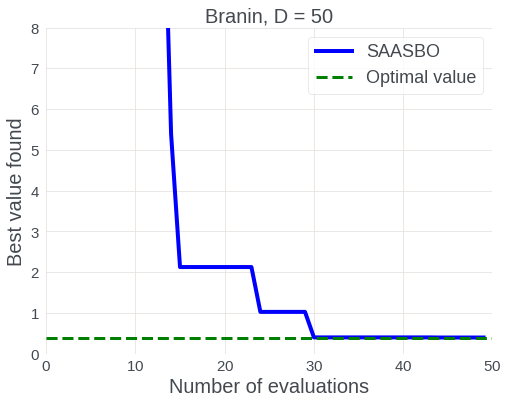

In [13]:
Y_np = Y.cpu().numpy()
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.minimum.accumulate(Y_np), color="b", label="SAASBO")
ax.plot([0, len(Y_np)], [0.398, 0.398], "--", c="g", lw=3, label="Optimal value")
ax.grid(True)
ax.set_title(f"Branin, D = {DIM}", fontsize=20)
ax.set_xlabel("Number of evaluations", fontsize=20)
ax.set_xlim([0, len(Y_np)])
ax.set_ylabel("Best value found", fontsize=20)
ax.set_ylim([0, 8])
ax.legend(fontsize=18)
plt.show()

## Predict on some test points
We fit a model using 50 datapoints and predict on 50 test 
points in order to see how well the SAAS model predicts out-of-sample.
The plot shows the mean and a 95% confidence interval for each test point.

In [14]:
train_X = SobolEngine(dimension=DIM, scramble=True, seed=0).draw(50).to(**tkwargs)
test_X = SobolEngine(dimension=DIM, scramble=True, seed=1).draw(50).to(**tkwargs)
train_Y = branin_emb(train_X).unsqueeze(-1)
test_Y = branin_emb(test_X).unsqueeze(-1)

gp = SaasFullyBayesianSingleTaskGP(
    train_X=train_X, train_Y=train_Y, train_Yvar=torch.full_like(train_Y, 1e-6), outcome_transform=Standardize(m=1)
)
fit_fully_bayesian_model_nuts(gp, warmup_steps=WARMUP_STEPS, num_samples=NUM_SAMPLES)

Sample: 100%|██████████| 768/768 [01:45,  7.27it/s, step size=3.46e-01, acc. prob=0.896]


In [15]:
with torch.no_grad():
    posterior = gp.posterior(test_X, marginalize_over_mcmc_samples=True)
    mean, var = posterior.mean, posterior.variance

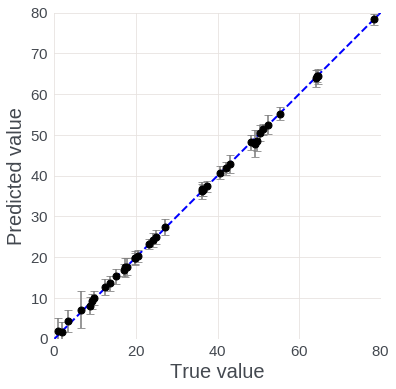

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot([0, 80], [0, 80], "b--", lw=2)
markers, caps, bars = ax.errorbar(
    test_Y.squeeze(-1).cpu().numpy(),
    mean.squeeze(-1).cpu().numpy(),
    yerr=1.96 * var.squeeze(-1).sqrt().cpu().numpy(),
    fmt=".",
    capsize=4,
    elinewidth=2.0,
    ms=14,
    c="k",
    ecolor="gray",
)
ax.set_xlim([0, 80])
ax.set_ylim([0, 80])
[bar.set_alpha(0.8) for bar in bars]
[cap.set_alpha(0.8) for cap in caps]
ax.set_xlabel("True value", fontsize=20)
ax.set_ylabel("Predicted value", fontsize=20)
ax.set_aspect("equal")
ax.grid(True)

## Look a the lengthscales from the final model

As SAASBO places strong priors on the inverse lengthscales, we only expect parameters 
0 and 1 to be identified as important by the model since the other parameters have no effect.
We can confirm that this is the case below as the lengthscales of parameters 0 and 1 are 
small with all other lengthscales being large.

In [17]:
median_lengthscales = gp.median_lengthscale
for i in median_lengthscales.argsort()[:10]:
    print(f"Parameter {i:2}) Median lengthscale = {median_lengthscales[i].item():.2e}")

Parameter  0) Median lengthscale = 7.60e-01
Parameter  1) Median lengthscale = 2.36e+00
Parameter 33) Median lengthscale = 1.06e+03
Parameter 42) Median lengthscale = 1.16e+03
Parameter 35) Median lengthscale = 1.18e+03
Parameter 39) Median lengthscale = 1.21e+03
Parameter  4) Median lengthscale = 1.28e+03
Parameter  5) Median lengthscale = 1.29e+03
Parameter 17) Median lengthscale = 1.32e+03
Parameter 13) Median lengthscale = 1.33e+03
